In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Setup
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

In [ ]:
!pip uninstall -y tensorflow estimator keras

In [ ]:
!pip install -U tensorflow_text tensorflow tensorflow_datasets

In [ ]:
!pip install einops

In [6]:
import concurrent.futures
import collections
import dataclasses
import hashlib
import itertools
import json
import math
import os
import pathlib
import random
import re
import string
import time
import urllib.request

import einops
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import requests
import tqdm

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_datasets as tfds

In [7]:
#Data Handling
import cv2
import numpy as np
import os
import json
from tqdm.notebook import tqdm
import pickle
import pandas as pd

In [8]:
class banglaDataset():
  def loadData(self):
    json_path = "/content/drive/MyDrive/caption_project/datasets/captions.json"

    f = open(json_path, encoding = "utf-8")

    images = []
    captions = []

    json_f = json.load(f)
    for d in tqdm(json_f):
        # print(d)
        # print(d['filename'])

        #read image
        img_file = "/content/drive/MyDrive/caption_project/datasets/images/" + d['filename']
        img = cv2.imread(img_file)
        if img is None:
            print("image is None")
            continue

        img = cv2.resize(img, (224, 224))

        images.append(img)

        caption = d['caption']
        captions.append(caption)
    

    #convert to numpy array
    images = np.array(images)
    captions = np.array(captions)

    print(images.shape)
    print(captions.shape)

    return images, captions

  def createFnameCaptionMap(self):
    json_path = "/content/drive/MyDrive/caption_project/datasets/captions.json"

    f = open(json_path, encoding = "utf-8")

    json_f = json.load(f)
    cap_dict = collections.defaultdict(list)

    for d in tqdm(json_f):
      f_name = "/content/drive/MyDrive/caption_project/datasets/images/" + d['filename']
      captions = d['caption']
      cap_dict[f_name] = captions

    # print(cap_dict)

    return cap_dict

  def splitData(self, cap_dict, test_size = 0.1):
    json_path = "/content/drive/MyDrive/caption_project/datasets/captions.json"
    f = open(json_path, encoding = "utf-8")
    json_f = json.load(f)

    train_files = []
    test_files = []

    train_size = 9154*(1-test_size)

    i = 0
    for d in tqdm(json_f):
      f_name = d['filename']
      if i <= train_size:
        train_files.append(f_name)
      else:
        test_files.append(f_name)
      i+=1

    # print(train_files)

    train_captions = [(str("/content/drive/MyDrive/caption_project/datasets/images/"+f_name), cap_dict[str("/content/drive/MyDrive/caption_project/datasets/images/"+f_name)]) for f_name in train_files]
    test_captions = [(str("/content/drive/MyDrive/caption_project/datasets/images/"+f_name), cap_dict[str("/content/drive/MyDrive/caption_project/datasets/images/"+f_name)]) for f_name in test_files]

    train_ds = tf.data.experimental.from_list(train_captions)
    test_ds = tf.data.experimental.from_list(test_captions)

    
    return train_ds, test_ds

Flickr8K Bangla

In [9]:
class flickr8kBangla():
  def createFnameCaptionMap(self):
    csv_path = "/content/drive/MyDrive/caption_project/datasets/BAN-Cap_captiondata.csv"
    df = pd.read_csv(csv_path)

    #extract the image paths and captions
    image_paths = df['caption_id'].tolist()
    captions = df['bengali_caption'].tolist()

    cap_dict  = collections.defaultdict(list)

    for i in range(len(image_paths)):
        image_name = image_paths[i].split('#')[0]
        cap_dict[image_name].append(captions[i])

    return cap_dict


  def splitData(self, cap_dict, test_size = 0.1):
    csv_path = "/content/drive/MyDrive/caption_project/datasets/BAN-Cap_captiondata.csv"
    df = pd.read_csv(csv_path)

    #extract the image paths and captions
    image_paths = df['caption_id'].tolist()
    captions = df['bengali_caption'].tolist()

    image_names = list(set([i.split('#')[0] for i in image_paths]))

    train_files = []
    test_files = []

    train_size = 8090*(1-test_size)

    i=0

    for d in tqdm(image_names):
      if i <= train_size:
        train_files.append(d)
      else:
        test_files.append(d)

      i+=1

    train_captions = [(str("/content/drive/MyDrive/flickr_Images/"+f_name), cap_dict[f_name]) for f_name in train_files]
    test_captions = [(str("/content/drive/MyDrive/flickr_Images/"+f_name), cap_dict[f_name]) for f_name in test_files]

    print(test_captions)

    train_ds = tf.data.experimental.from_list(train_captions)
    test_ds = tf.data.experimental.from_list(test_captions)

    
    return train_ds, test_ds

In [ ]:
bd = banglaDataset()
bd_images, bd_captions = bd.loadData()
print(bd_images.shape)
print(bd_captions.shape)

In [ ]:
#Save in a picle 
pickle_path = "/content/drive/MyDrive/caption_project/pickles/bangla_data.pkl"
with open(pickle_path, "wb") as f:
        pickle.dump((bd_images, bd_captions), f)

In [10]:
bd = flickr8kBangla()
cap_dict = bd.createFnameCaptionMap()

In [11]:
train_captions, test_captions = bd.splitData(cap_dict)
print(type(train_captions))

  0%|          | 0/8091 [00:00<?, ?it/s]

[('/content/drive/MyDrive/flickr_Images/3124838157_7ef96745b7.jpg', ['একজন মহিলা এবং দুই পুরুষ একটি খুচরা দোকানের বাইরে পোজ দিচ্ছেন', 'দোকানের সামনে তিনজন লোক দাঁড়িয়ে আছে', 'তিনজন ব্যক্তি দোকানের জানালার সামনে দাঁড়িয়ে হাসল।', 'তিনজন লোক একটি দোকানের চিহ্নের সামনে দাড়িয়ে আছে', 'দুই লম্বা ব্যক্তি এবং এক খাটো নারী একটি ক্লোজ আউট দোকানের সামনে দাঁড়ানো।']), ('/content/drive/MyDrive/flickr_Images/2527713011_b0ec25aa54.jpg', ['একটি কালো এবং সাদা রেলীর গাড়ি মোড় নেয়', 'গ্লোবাল গ্রুপের একটি রেস গাড়ি', 'কালো এবং সাদা রেস গাড়িটি ট্র্যাকের চারপাশে দ্রুত চলছে যখন ভক্তরা কাছাকাছি দেখছেন।', 'এক সাদা ও কালো রঙের গাড়ী মোড় নিচ্ছে', 'দৌড় প্রতিযোগিতার গাড়ীটি পাহাড়ে গতি বাড়াচ্ছে']), ('/content/drive/MyDrive/flickr_Images/2696866120_254a0345bc.jpg', ['ক্যামেরার সামনে একটি নোংরা কুকুর ময়লায় গড়াগড়ি খাচ্ছে', 'একটি কুকুর মাটিতে শুয়ে আছে।', 'একটি কুকুর মাটিতে মোচড়ায়', 'এক কুকুর মাটিতে গড়াগড়ি খাচ্ছে', 'বাদামী কুকুরটি ময়লায় গড়াগড়ি করছে।']), ('/content/drive/MyDrive/flickr_Images/3618932839_acd7d2c2ea.

In [12]:
choose = 'bangla'
if choose == 'bangla':
  # train_raw, test_raw = conceptual_captions(num_train=10000, num_val=5000)
  bd = banglaDataset()
  cap_dict = bd.createFnameCaptionMap()
  train_raw, test_raw = bd.splitData(cap_dict)

elif choose == 'flickr8k_bangla':
  bd = flickr8kBangla()
  cap_dict = bd.createFnameCaptionMap()
  train_raw, test_raw = bd.splitData(cap_dict)


  0%|          | 0/8091 [00:00<?, ?it/s]

[('/content/drive/MyDrive/flickr_Images/3124838157_7ef96745b7.jpg', ['একজন মহিলা এবং দুই পুরুষ একটি খুচরা দোকানের বাইরে পোজ দিচ্ছেন', 'দোকানের সামনে তিনজন লোক দাঁড়িয়ে আছে', 'তিনজন ব্যক্তি দোকানের জানালার সামনে দাঁড়িয়ে হাসল।', 'তিনজন লোক একটি দোকানের চিহ্নের সামনে দাড়িয়ে আছে', 'দুই লম্বা ব্যক্তি এবং এক খাটো নারী একটি ক্লোজ আউট দোকানের সামনে দাঁড়ানো।']), ('/content/drive/MyDrive/flickr_Images/2527713011_b0ec25aa54.jpg', ['একটি কালো এবং সাদা রেলীর গাড়ি মোড় নেয়', 'গ্লোবাল গ্রুপের একটি রেস গাড়ি', 'কালো এবং সাদা রেস গাড়িটি ট্র্যাকের চারপাশে দ্রুত চলছে যখন ভক্তরা কাছাকাছি দেখছেন।', 'এক সাদা ও কালো রঙের গাড়ী মোড় নিচ্ছে', 'দৌড় প্রতিযোগিতার গাড়ীটি পাহাড়ে গতি বাড়াচ্ছে']), ('/content/drive/MyDrive/flickr_Images/2696866120_254a0345bc.jpg', ['ক্যামেরার সামনে একটি নোংরা কুকুর ময়লায় গড়াগড়ি খাচ্ছে', 'একটি কুকুর মাটিতে শুয়ে আছে।', 'একটি কুকুর মাটিতে মোচড়ায়', 'এক কুকুর মাটিতে গড়াগড়ি খাচ্ছে', 'বাদামী কুকুরটি ময়লায় গড়াগড়ি করছে।']), ('/content/drive/MyDrive/flickr_Images/3618932839_acd7d2c2ea.

In [13]:
train_raw.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(5,), dtype=tf.string, name=None))

In [14]:
for ex_path, ex_captions in train_raw.take(1):
  print(ex_path)
  print(ex_captions)

tf.Tensor(b'/content/drive/MyDrive/flickr_Images/3596959859_a7cb1e194b.jpg', shape=(), dtype=string)
tf.Tensor(
[b'\xe0\xa6\x8f\xe0\xa6\x95\xe0\xa6\xa6\xe0\xa6\xb2 \xe0\xa6\xb2\xe0\xa7\x8b\xe0\xa6\x95 \xe0\xa6\x9b\xe0\xa6\xbe\xe0\xa6\xa6\xe0\xa7\x87\xe0\xa6\xb0 \xe0\xa6\xac\xe0\xa7\x87\xe0\xa6\xb6 \xe0\xa6\x95\xe0\xa6\xaf\xe0\xa6\xbc\xe0\xa7\x87\xe0\xa6\x95\xe0\xa6\x9f\xe0\xa6\xbf \xe0\xa6\x95\xe0\xa7\x81\xe0\xa6\x81\xe0\xa6\xa1\xe0\xa6\xbc\xe0\xa7\x87 \xe0\xa6\x98\xe0\xa6\xb0 \xe0\xa6\xa5\xe0\xa7\x87\xe0\xa6\x95\xe0\xa7\x87 \xe0\xa6\xae\xe0\xa6\xbe\xe0\xa6\x9f\xe0\xa6\xbf \xe0\xa6\xa8\xe0\xa6\xbe\xe0\xa6\xae\xe0\xa6\xbe\xe0\xa6\x9a\xe0\xa7\x8d\xe0\xa6\x9b\xe0\xa7\x87 \xe0\xa6\xac\xe0\xa6\xb2\xe0\xa7\x87 \xe0\xa6\xae\xe0\xa6\xa8\xe0\xa7\x87 \xe0\xa6\xb9\xe0\xa6\x9a\xe0\xa7\x8d\xe0\xa6\x9b\xe0\xa7\x87'
 b'\xe0\xa6\xb6\xe0\xa7\x8d\xe0\xa6\xb0\xe0\xa6\xae\xe0\xa6\xbf\xe0\xa6\x95\xe0\xa6\xa6\xe0\xa7\x87\xe0\xa6\xb0 \xe0\xa6\x8f\xe0\xa6\x95\xe0\xa6\x9f\xe0\xa6\xbf \xe0\xa6\xa6\xe0\xa6\xb2 \

In [15]:
#Extract Image Features
IMAGE_SHAPE=(224, 224, 3)
mobilenet = tf.keras.applications.MobileNetV3Small(
    input_shape=IMAGE_SHAPE,
    include_top=False,
    include_preprocessing=True)
mobilenet.trainable=False

4334752/4334752 [==============================] - 0s 0us/step


In [16]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SHAPE[:-1])
    return img

In [17]:
test_img_batch = load_image(ex_path)[tf.newaxis, :]

print(test_img_batch.shape)
print(mobilenet(test_img_batch).shape)

(1, 224, 224, 3)
(1, 7, 7, 576)


In [18]:
def standardize(s):
  # s = tf.strings.lower(s)
  s = tf.strings.regex_replace(s, f'[{re.escape(string.punctuation)}]', '')
  s = tf.strings.join(['[START]', s, '[END]'], separator=' ')
  return s

In [19]:
# Use the top 5000 words for a vocabulary.
vocabulary_size = 10000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    ragged=True)
# Learn the vocabulary from the caption data.

In [20]:
tokenizer.adapt(train_raw.map(lambda fp,txt: txt).unbatch().batch(1024))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [21]:
tokenizer.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', 'একটি', 'একজন', 'কুকুর', 'এক', 'লোক', 'আছে']

In [22]:
# Create mappings for words to indices and indices to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

In [23]:
#The train_raw and test_raw datasets contain 1:many (image, captions) pairs.

#This function will replicate the image so there are 1:1 images to captions:
def match_shapes(images, captions):
  caption_shape = einops.parse_shape(captions, 'b c')
  captions = einops.rearrange(captions, 'b c -> (b c)')
  images = einops.repeat(
      images, 'b ... -> (b c) ...',
      c = caption_shape['c'])
  return images, captions

In [24]:
for ex_paths, ex_captions in train_raw.batch(32).take(1):
  break

print('image paths:', ex_paths.shape)
print('captions:', ex_captions.shape)
print()

ex_paths, ex_captions = match_shapes(images=ex_paths, captions=ex_captions)

print('image_paths:', ex_paths.shape)
print('captions:', ex_captions.shape)

image paths: (32,)
captions: (32, 5)

image_paths: (160,)
captions: (160,)


In [25]:
#To be compatible with keras training the dataset should contain (inputs, labels) pairs. For text generation the tokens are both an input and the labels, shifted by one step. This function will convert an (images, texts) pair to an ((images, input_tokens), label_tokens) pair:
def prepare_txt(imgs, txts):
  tokens = tokenizer(txts)

  input_tokens = tokens[..., :-1]
  label_tokens = tokens[..., 1:]
  return (imgs, input_tokens), label_tokens

In [26]:
def prepare_dataset(ds, tokenizer, batch_size=32, shuffle_buffer=1000):
  # Load the images and make batches.
  ds = (ds
        .shuffle(10000)
        .map(lambda path, caption: (load_image(path), caption))
        .apply(tf.data.experimental.ignore_errors())
        .batch(batch_size))

  def to_tensor(inputs, labels):
    (images, in_tok), out_tok = inputs, labels
    return (images, in_tok.to_tensor()), out_tok.to_tensor()

  return (ds
          .map(match_shapes, tf.data.AUTOTUNE)
          .unbatch()
          .shuffle(shuffle_buffer)
          .batch(batch_size)
          .map(prepare_txt, tf.data.AUTOTUNE)
          .map(to_tensor, tf.data.AUTOTUNE)
          )

In [ ]:
train_ds = prepare_dataset(train_raw, tokenizer)
train_ds.element_spec

In [ ]:
test_ds = prepare_dataset(test_raw, tokenizer)
test_ds.element_spec

In [ ]:
for (inputs, ex_labels) in train_ds.take(1):
  (ex_img, ex_in_tok) = inputs

print(ex_img.shape)
print(ex_in_tok.shape)
print(ex_labels.shape)

In [ ]:
print(ex_img[0])
print(ex_in_tok[0])
print(ex_labels[0])

In [31]:
class SeqEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, max_length, depth):
    super().__init__()
    self.pos_embedding = tf.keras.layers.Embedding(input_dim=max_length, output_dim=depth)

    self.token_embedding = tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=depth,
        mask_zero=True)
    
    self.add = tf.keras.layers.Add()

  def call(self, seq):
    seq = self.token_embedding(seq) # (batch, seq, depth)

    x = tf.range(tf.shape(seq)[1])  # (seq)
    x = x[tf.newaxis, :]  # (1, seq)
    x = self.pos_embedding(x)  # (1, seq, depth)

    return self.add([seq,x])

In [32]:
class CausalSelfAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    # Use Add instead of + so the keras mask propagates through.
    self.add = tf.keras.layers.Add() 
    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x):
    attn = self.mha(query=x, value=x,
                    use_causal_mask=True)
    x = self.add([x, attn])
    return self.layernorm(x)


In [33]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self,**kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.add = tf.keras.layers.Add() 
    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x, y, **kwargs):
    attn, attention_scores = self.mha(
             query=x, value=y,
             return_attention_scores=True)
    
    self.last_attention_scores = attention_scores

    x = self.add([x, attn])
    return self.layernorm(x)

In [34]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, units, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
        tf.keras.layers.Dense(units=2*units, activation='relu'),
        tf.keras.layers.Dense(units=units),
        tf.keras.layers.Dropout(rate=dropout_rate),
    ])

    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x):
    x = x + self.seq(x)
    return self.layernorm(x)

In [35]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, units, num_heads=1, dropout_rate=0.1):
    super().__init__()
    
    self.self_attention = CausalSelfAttention(num_heads=num_heads,
                                              key_dim=units,
                                              dropout=dropout_rate)
    self.cross_attention = CrossAttention(num_heads=num_heads,
                                          key_dim=units,
                                          dropout=dropout_rate)
    self.ff = FeedForward(units=units, dropout_rate=dropout_rate)
      

  def call(self, inputs, training=False):
    in_seq, out_seq = inputs

    # Text input
    out_seq = self.self_attention(out_seq)

    out_seq = self.cross_attention(out_seq, in_seq)
    
    self.last_attention_scores = self.cross_attention.last_attention_scores

    out_seq = self.ff(out_seq)

    return out_seq

In [36]:
import tqdm
class TokenOutput(tf.keras.layers.Layer):
  def __init__(self, tokenizer, banned_tokens=('', '[UNK]', '[START]'), **kwargs):
    super().__init__()
    
    self.dense = tf.keras.layers.Dense(
        units=tokenizer.vocabulary_size(), **kwargs)
    self.tokenizer = tokenizer
    self.banned_tokens = banned_tokens

    self.bias = None

  def adapt(self, ds):
    counts = collections.Counter()
    vocab_dict = {name: id 
                  for id, name in enumerate(self.tokenizer.get_vocabulary())}

    for tokens in tqdm.tqdm(ds):
      counts.update(tokens.numpy().flatten())

    counts_arr = np.zeros(shape=(self.tokenizer.vocabulary_size(),))
    counts_arr[np.array(list(counts.keys()), dtype=np.int32)] = list(counts.values())

    counts_arr = counts_arr[:]
    for token in self.banned_tokens:
      counts_arr[vocab_dict[token]] = 0

    total = counts_arr.sum()
    p = counts_arr/total
    p[counts_arr==0] = 1.0
    log_p = np.log(p)  # log(1) == 0

    entropy = -(log_p*p).sum()

    print()
    print(f"Uniform entropy: {np.log(self.tokenizer.vocabulary_size()):0.2f}")
    print(f"Marginal entropy: {entropy:0.2f}")

    self.bias = log_p
    self.bias[counts_arr==0] = -1e9

  def call(self, x):
    x = self.dense(x)
    # TODO(b/250038731): Fix this.
    # An Add layer doesn't work because of the different shapes.
    # This clears the mask, that's okay because it prevents keras from rescaling
    # the losses.
    return x + self.bias

In [37]:
output_layer = TokenOutput(tokenizer, banned_tokens=('', '[UNK]', '[START]'))
# This might run a little faster if the dataset didn't also have to load the image data.
output_layer.adapt(train_ds.map(lambda inputs, labels: labels))

1138it [25:25,  1.34s/it]


Uniform entropy: 8.52
Marginal entropy: 5.99


In [38]:
class Captioner(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, tokenizer, feature_extractor, output_layer, num_layers=1,
               units=256, max_length=50, num_heads=1, dropout_rate=0.1):
    super().__init__()
    self.feature_extractor = feature_extractor
    self.tokenizer = tokenizer
    self.word_to_index = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary())
    self.index_to_word = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary(),
        invert=True) 

    self.seq_embedding = SeqEmbedding(
        vocab_size=tokenizer.vocabulary_size(),
        depth=units,
        max_length=max_length)

    self.decoder_layers = [
        DecoderLayer(units, num_heads=num_heads, dropout_rate=dropout_rate)
        for n in range(num_layers)]

    self.output_layer = output_layer

In [39]:
@Captioner.add_method
def call(self, inputs):
  image, txt = inputs

  if image.shape[-1] == 3:
    # Apply the feature-extractor, if you get an RGB image.
    image = self.feature_extractor(image)
  
  # Flatten the feature map
  image = einops.rearrange(image, 'b h w c -> b (h w) c')


  if txt.dtype == tf.string:
    # Apply the tokenizer if you get string inputs.
    txt = tokenizer(txt)

  txt = self.seq_embedding(txt)

  # Look at the image
  for dec_layer in self.decoder_layers:
    txt = dec_layer(inputs=(image, txt))
    
  txt = self.output_layer(txt)

  return txt

In [40]:
model = Captioner(tokenizer, feature_extractor=mobilenet, output_layer=output_layer,
                  units=256, dropout_rate=0.5, num_layers=2, num_heads=2)

In [41]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
image = load_image(image_path)

64400/64400 [==============================] - 0s 3us/step


In [42]:
@Captioner.add_method
def simple_gen(self, image, temperature=1):
  initial = self.word_to_index([['[START]']]) # (batch, sequence)
  img_features = self.feature_extractor(image[tf.newaxis, ...])

  tokens = initial # (batch, sequence)
  for n in range(50):
    preds = self((img_features, tokens)).numpy()  # (batch, sequence, vocab)
    preds = preds[:,-1, :]  #(batch, vocab)
    if temperature==0:
        next = tf.argmax(preds, axis=-1)[:, tf.newaxis]  # (batch, 1)
    else:
        next = tf.random.categorical(preds/temperature, num_samples=1)  # (batch, 1)
    tokens = tf.concat([tokens, next], axis=1) # (batch, sequence) 

    if next[0] == self.word_to_index('[END]'):
      break
  words = index_to_word(tokens[0, 1:-1])
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  return result.numpy().decode()

In [43]:
for t in (0.0, 0.5, 1.0):
  result = model.simple_gen(image, temperature=t)
  print(result)



এক পানির


Train

In [44]:
def masked_loss(labels, preds):  
  loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels, preds)

  mask = (labels != 0) & (loss < 1e8) 
  mask = tf.cast(mask, loss.dtype)

  loss = loss*mask
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

def masked_acc(labels, preds):
  mask = tf.cast(labels!=0, tf.float32)
  preds = tf.argmax(preds, axis=-1)
  labels = tf.cast(labels, tf.int64)
  match = tf.cast(preds == labels, mask.dtype)
  acc = tf.reduce_sum(match*mask)/tf.reduce_sum(mask)
  return acc

In [45]:
class GenerateText(tf.keras.callbacks.Callback):
  def __init__(self):
    image_url = 'https://tensorflow.org/images/surf.jpg'
    image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
    self.image = load_image(image_path)

  def on_epoch_end(self, epochs=None, logs=None):
    print()
    print()
    for t in (0.0, 0.5):
      result = self.model.simple_gen(self.image, temperature=t)
      print(result)
    print()

In [46]:
g = GenerateText()
g.model = model
g.on_epoch_end(0)




উপর একটি



In [47]:
callbacks = [
    GenerateText(),
    tf.keras.callbacks.EarlyStopping(
        patience=5, restore_best_weights=True)]

In [48]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
           loss=masked_loss,
           metrics=[masked_acc])

In [49]:
history = model.fit(
    train_ds.repeat(),
    steps_per_epoch=100,
    validation_data=test_ds.repeat(),
    validation_steps=20,
    epochs=100,
    callbacks=callbacks)

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 5.8229 - masked_acc: 0.1478

একটি কুকুর একটি একটি একটি কুকুর
একটি মহিলা পাহাড়ের ক্যামেরার থেকে

100/100 [==============================] - 215s 2s/step - loss: 5.8229 - masked_acc: 0.1478 - val_loss: 5.5722 - val_masked_acc: 0.1741
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 5.5142 - masked_acc: 0.1799

একটি কুকুর একটি কুকুর একটি কুকুর একটি কুকুর একটি কুকুর
একটি কুকুর একটি কালো ছোট লোক একটি কালো কালো বসে

100/100 [==============================] - 179s 2s/step - loss: 5.5142 - masked_acc: 0.1799 - val_loss: 5.2947 - val_masked_acc: 0.1994
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 5.3181 - masked_acc: 0.2014

একটি কুকুর একটি কুকুর একটি কুকুর একটি কুকুর
একজন লোক একটি কুকুর খেলছে

100/100 [==============================] - 175s 2s/step - loss: 5.3181 - masked_acc: 0.2014 - val_loss: 5.1060 - val_masked_acc: 0.2203
Epoch 4/100
100/100 [=============================

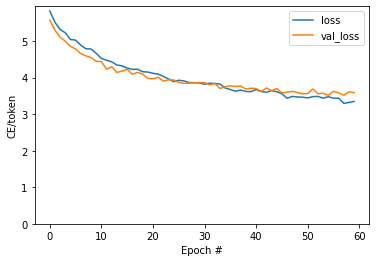

In [50]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

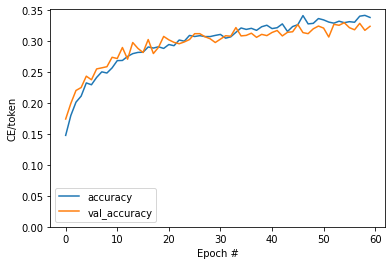

In [51]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

In [52]:
result = model.simple_gen(image, temperature=0.5)
result

'একজন লোক এবং নীল সার্ফবোর্ড নিয়ে সাঁতার কাটছে'

In [53]:
str_tokens = result.split()
str_tokens.append('[END]')

In [54]:
attn_maps = [layer.last_attention_scores for layer in model.decoder_layers]
[map.shape for map in attn_maps]

[TensorShape([1, 2, 9, 49]), TensorShape([1, 2, 9, 49])]

In [55]:
attention_maps = tf.concat(attn_maps, axis=0)
attention_maps = einops.reduce(
    attention_maps,
    'batch heads sequence (height width) -> sequence height width',
    height=7, width=7,
    reduction='mean')

In [ ]:
einops.reduce(attention_maps, 'sequence height width -> sequence', reduction='sum')

In [57]:
def plot_attention_maps(image, str_tokens, attention_map):
    fig = plt.figure(figsize=(16, 9))

    len_result = len(str_tokens)
    
    titles = []
    for i in range(len_result):
      map = attention_map[i]
      grid_size = max(int(np.ceil(len_result/2)), 2)
      ax = fig.add_subplot(3, grid_size, i+1)
      titles.append(ax.set_title(str_tokens[i]))
      img = ax.imshow(image)
      ax.imshow(map, cmap='gray', alpha=0.6, extent=img.get_extent(),
                clim=[0.0, np.max(map)])

    plt.tight_layout()

In [ ]:
plot_attention_maps(image/255, str_tokens, attention_maps)

In [59]:
@Captioner.add_method
def run_and_show_attention(self, image, temperature=0.0):
  result_txt = self.simple_gen(image, temperature)
  print(result_txt)
  str_tokens = result_txt.split()
  str_tokens.append('[END]')

  attention_maps = [layer.last_attention_scores for layer in self.decoder_layers]
  attention_maps = tf.concat(attention_maps, axis=0)
  attention_maps = einops.reduce(
      attention_maps,
      'batch heads sequence (height width) -> sequence height width',
      height=7, width=7,
      reduction='mean')
  
  plot_attention_maps(image/255, str_tokens, attention_maps)
  t = plt.suptitle(result_txt)
  t.set_y(1.05)

In [ ]:
run_and_show_attention(model, image)

In [ ]:
image_path = '/content/drive/MyDrive/caption_project/datasets/images/6946.png'
image = load_image(image_path)

run_and_show_attention(model, image)

In [ ]:
image_url = 'https://clicklovegrow.com/wp-content/uploads/2019/08/7-2.jpg'
image_path = tf.keras.utils.get_file(origin=image_url)
image = load_image(image_path)

run_and_show_attention(model, image)